# First attempt for implementation of "A faster algorithm for the calculation of the fast spectral correlation" by P. Borghesani & J. Antoni 

In [1]:
import numpy as np
from scipy.signal import iirfilter, lfilter, periodogram, stft
from numpy.lib.stride_tricks import sliding_window_view

import matplotlib.pyplot as plt
# %matplotlib notebook
figsize = [19, 5]

# sampling rate
fs = 10**6 #samples / seconds
nSamples = 10**6

modFreq = 50 #Hz
carrierFreq = 225e+3 #Hz
bandWidth = 25e+3 #Hz
filtOrd = 2 
nHarmonics = 20
filtWn = [(carrierFreq - bandWidth) / (fs / 2), (carrierFreq + bandWidth) / (fs / 2)] #normalized frequency 

### signal simulation - noise modulating with 50 Hz

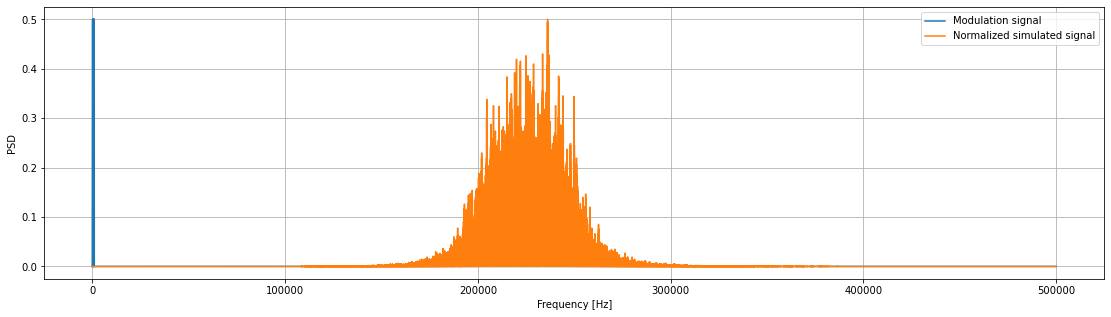

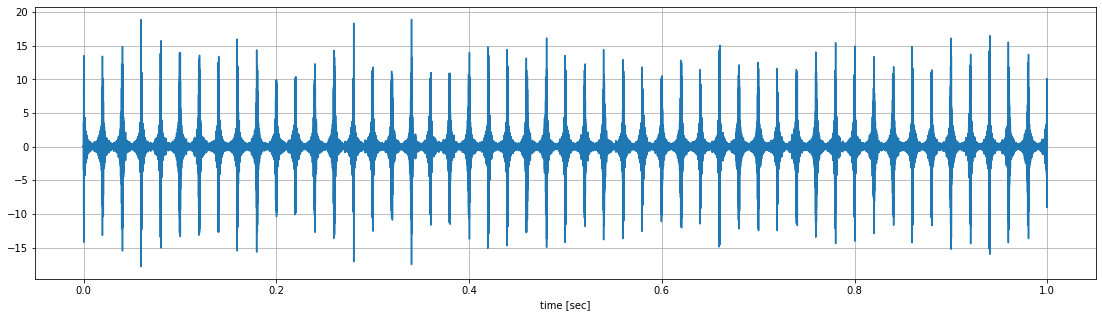

In [2]:
t = np.arange(nSamples) / fs # time vector in seconds

# simulating the modulation signal
x = np.zeros_like(t)
for h in range(1, nHarmonics):
    x += np.sin(h * modFreq * np.pi * 2 * t) 

#spectrums
plt.figure(figsize=figsize)
# spectrum of the simulated modulation signal
f, pxx = periodogram(x, fs) 
plt.plot(f, pxx)

# simulation of the noise multiplied by the modulation signal
x *= np.random.randn(t.shape[0])
# filtering of the modulating noise
b, a = iirfilter(filtOrd, filtWn)
x = lfilter(b, a, x)

# spectrum of the modulated filtered noise - normalized the scale for the visualization
f, pxx = periodogram(x, fs)
plt.plot(f, pxx / pxx.max() * 0.5)
plt.grid()
# plt.xlim([0, h * modFreq])
plt.legend(['Modulation signal', 'Normalized simulated signal'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()

# also ploting the time domain of the filtered modulated signal
plt.figure(figsize=figsize)
plt.plot(t, x)
plt.grid()
plt.xlabel('time [sec]')
plt.show()

### here I create the same signal for the second time for another figure - zoom view

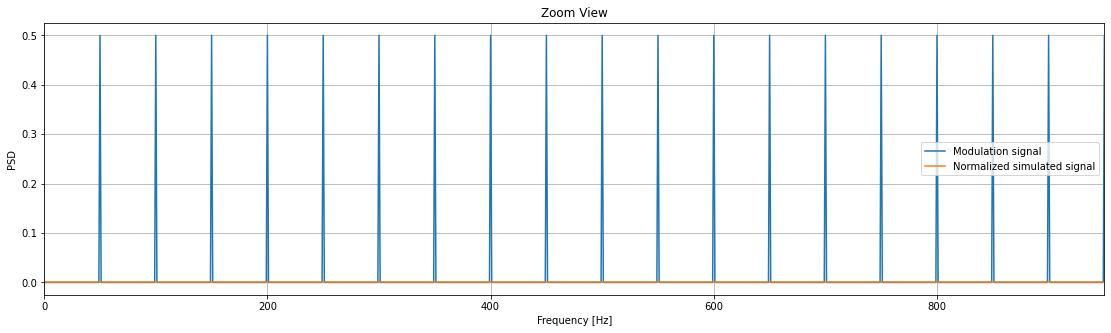

In [3]:
x = np.zeros_like(t)
for h in range(1, nHarmonics):
    x += np.sin(h * modFreq * np.pi * 2 * t) 

plt.figure(figsize=figsize)
f, pxx = periodogram(x, fs)
plt.plot(f, pxx)

x *= np.random.randn(t.shape[0])
b, a = iirfilter(filtOrd, filtWn)
x = lfilter(b, a, x)

f, pxx = periodogram(x, fs)
plt.plot(f, pxx / pxx.max() * 0.5)
plt.grid()
# plt.xlim([0, h * modFreq])
plt.title('Zoom View')
plt.legend(['Modulation signal', 'Normalized simulated signal'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim([0, h * modFreq])
plt.show()

In [ ]:
def CPS_W(inputs): 
    import numpy as np
    from scipy.signal import stft
    x, alpha, nfft, Noverlap, winSize = inputs
#   x - signal
#   alpha - normalized modulation siganal
    Window = np.hanning(winSize)
    
    # compute CPS
    f = np.arange(nfft) / nfft
    t = np.arange(x.size)
    y = x * np.exp(2j * np.pi * alpha * t)
        
    _, _, xFFT = stft(x, fs=1.0, window=Window, nperseg=winSize, noverlap=Noverlap, nfft=nfft, detrend=False, 
                      return_onesided=False, boundary='zeros', padded=True, axis=- 1)
    f, _, yFFT = stft(y, fs=1.0, window=Window, nperseg=winSize, noverlap=Noverlap, nfft=nfft, detrend=False, 
                      return_onesided=False, boundary='zeros', padded=True, axis=- 1)
    
    CPS = np.sum(xFFT[f >= 0, :] * np.conjugate(yFFT[f >= 0, :]), axis=1)
    return CPS

In [ ]:
def getParams(fs, alphaMax=1000, df=100, fMin=5e+4):
    # alphaMax - max modulation frequency
    # df - carrier frequency resolution
    # fMin - min carrier frequency

    # STFT windows' hop
    R = int(np.floor(fs / (2 * alphaMax))) #shift of the stft
    # STFT window length
    Nw = int(fs / df)
    # number of STFT windows
#     M = int((x.size - Nw) / R + 1)

    # hannind window
    w = np.hanning(Nw)
    # Dirichlet kernel parameter
    P = int(np.round((Nw - 1) / (2 * R)))
    # Dirichlet kernel
    D = np.sum(
        [np.exp(2 * np.pi * 1j * p *(np.arange(Nw) - Nw / 2) / Nw) for p in np.arange(- P, P + 1)], 
        axis=0
    )
    D = D.real
    return fMin, R, Nw, w, D

In [ ]:
def getCS(x, fs, norm=False):
    fMin, R, Nw, w, D = getParams(fs)
    # buffering
    bufferX = sliding_window_view(x, (Nw, ), )[::R, :]

    # x_w
    bufferX_w = np.multiply(bufferX, w)
    # x_w^P
    bufferX_wD = np.multiply(bufferX, w * D)

    alpha = np.fft.fftfreq(bufferX.shape[0], R / fs)
    f = np.fft.fftfreq(bufferX.shape[1], 1 / fs)

    X_w   = np.fft.fft(bufferX_w, axis=1)
    x_w_d = np.fft.fft(bufferX_wD, axis=1)

    X_w = X_w[:, f >= fMin]
    x_w_d = x_w_d[:, f >= fMin]
    
    if norm:
        X_w = np.divide(X_w, np.sqrt(np.mean(X_w * np.conjugate(X_w), axis=0)))
        x_w_d = np.divide(x_w_d, np.sqrt(np.mean(x_w_d * np.conjugate(x_w_d), axis=0)))

    CS = np.fft.fft(np.conjugate(X_w) * x_w_d, axis=0)
    CS = CS[alpha >= 0, :]

    alpha = alpha[alpha >= 0]
    f = f[f >= fMin]
    
    return CS, f, alpha

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

def getCS_CMS(x, fs, norm=False):
    fMin, R, Nw, w, D = getParams(fs)
    # buffering
    bufferX = sliding_window_view(x, (Nw, ), )[::R, :]

    # x_w
    bufferX_w = np.multiply(bufferX, w)
    # x_w^P
    bufferX_wD = np.multiply(bufferX, w * D)

    alpha = np.fft.fftfreq(bufferX.shape[0], R / fs)
    f = np.fft.fftfreq(bufferX.shape[1], 1 / fs)

    X_w   = np.fft.fft(bufferX_w, axis=1)
    X_w = X_w[:, f >= fMin]
    
    if norm:
        X_w = np.divide(X_w, np.sum(np.abs(X_w), axis=0))

    CS_CMS = np.fft.fft(X_w * np.conjugate(X_w), axis=0)
    CS_CMS = CS_CMS[alpha >= 0, :]

    alpha = alpha[alpha >= 0]
    f = f[f >= fMin]
    
    return CS_CMS, f, alpha

In [ ]:
fMin, R, Nw, w, D = getParams(fs, alphaMax=1000, df=100, fMin=5e+4)

In [ ]:
CS, f, alpha = getCS(x, fs, norm=False)
CCoh, f, alpha = getCS(x, fs, norm=True)
CS_CMS, f, alpha = getCS_CMS(x, fs, norm=False)
CCoh_CMS, f, alpha = getCS_CMS(x, fs, norm=True)

In [ ]:
import ipyparallel as ipp
from glob import glob

f_ACP = np.fft.fftfreq(10000, 1 / fs)
f_ACP = f_ACP[f_ACP >= 0]
alpha_ACP = np.arange(1000)

inputs = [(x, a, Nw, Nw - R, Nw) for a in (alpha_ACP / fs)]
with ipp.Cluster() as rc:
    view = rc.load_balanced_view()
    asyncresult = view.map_async(CPS_W, inputs)
    asyncresult.wait_interactive()
    CS_ACP = np.array(asyncresult.get())

CS_ACP = CS_ACP[:, f_ACP >= fMin]
f_ACP = f_ACP[f_ACP >= fMin]
CCoh_ACP = np.divide(CS_ACP, CS_ACP[0, :])

In [ ]:
%matplotlib inline

figsize = [19, 7]
plt.figure(figsize=figsize)
plt.pcolormesh(alpha_ACP, f_ACP, np.abs(CS_ACP.T), shading='auto')
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Spectal corrlation by ACP')
plt.show()

figsize = [19, 7]
plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CS.T), shading='auto')
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Spectal corrlation by fast spectral correlation')
plt.show()

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CS_CMS.T), shading='auto')
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Spectal corrlation estimated by CMS')
plt.show()

figsize = [19, 7]
plt.figure(figsize=figsize)
plt.pcolormesh(alpha_ACP, f_ACP[f_ACP > fMin], np.abs(CCoh_ACP[:, f_ACP > fMin].T), shading='auto')
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Spectal coherence by ACP')
plt.show()

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CCoh.T), shading='auto')
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Coherance estimated by fast spectral correlation')
plt.show()

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f, np.abs(CCoh_CMS.T), shading='auto')
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency')
plt.title('Coherance estimated by CMS')
plt.show()

In [ ]:
EES_ACP = np.sum(np.abs(CS_ACP), axis=1)
EES_fast = np.sum(np.abs(CS), axis=1)
EES_CMS = np.sum(np.abs(CS_CMS), axis=1)

plt.figure(figsize=figsize)
plt.plot(alpha_ACP,  EES_ACP / EES_ACP.max() * EES_fast.max(), linewidth=8)
plt.plot(alpha, EES_fast, linewidth=6)
plt.plot(alpha, EES_CMS, linewidth=4)
plt.xlabel('Modulation Frequency [Hz]')
plt.ylabel('EES - CS')
plt.legend(['ACP', 'Faster', 'CMS'])
plt.grid()
plt.show()

In [ ]:
EES_ACP = np.sum(np.abs(CCoh_ACP), axis=1)
EES_fast = np.sum(np.abs(CCoh), axis=1)
EES_CMS = np.sum(np.abs(CCoh_CMS), axis=1)

plt.figure(figsize=figsize)
plt.plot(alpha_ACP,  EES_ACP / EES_ACP.max() * EES_fast.max(), linewidth=10)
plt.plot(alpha, EES_fast, linewidth=6)
plt.plot(alpha, EES_CMS, linewidth=3)
plt.xlabel('Modulation Frequency [Hz]')
plt.ylabel('EES - Coherence')
plt.legend(['ACP', 'Faster', 'CMS'])
plt.grid()
plt.show()

### removing the DC in the 0 (max) frequency in the ACP method to check the improvement in the compatibility

In [ ]:
EES_ACP = np.sum(np.abs(CCoh_ACP[:, f_ACP < f_ACP[-1] * 0.9]), axis=1)
EES_fast = np.sum(np.abs(CCoh[:,  f < f[-1] * 0.9]), axis=1)
EES_CMS = np.sum(np.abs(CCoh_CMS[:,  f < f[-1] * 0.9]), axis=1)

plt.figure(figsize=figsize)
plt.plot(alpha_ACP,  EES_ACP / EES_ACP.max() * EES_fast.max(), linewidth=10)
plt.plot(alpha, EES_fast, linewidth=6)
plt.plot(alpha, EES_CMS, linewidth=3)
plt.xlabel('Modulation Frequency [Hz]')
plt.ylabel('EES - Coherence')
plt.legend(['ACP', 'Faster', 'CMS'])
plt.grid()
plt.show()